In [1]:
import os, sys
import ROOT as rt
import json
import math
## user define
sys.path.append(".")
sys.path.append("./Utils")
from SystHelper import *
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
 
ALL_MASSES = setting["ALL_MASSES"]
PROCESSES = ["ttbar", "ww", "zp", "dy", "singletop", "wz", "zz", "others"]

INPUTDIR = sys.argv[1]
ERA = sys.argv[2]
REGION = sys.argv[3]
ONLY_BENCHMARK = sys.argv[4]

# # for dev
# INPUTDIR = "/eos/user/h/hkwon/SWAN_projects/Zpeak/Outputs/DNN/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/Preselection/20231214GEv1/DNN/"
# ERA = "em16"
# INPUTDIR += ERA
# REGION = "SR"
# ONLY_BENCHMARK = 'no'

year = ERA.replace("em", "")
year = year.replace("mm", "")
year = year.replace("ee", "")
channel = ERA.replace("16", "")
channel = channel.replace("17", "")
channel = channel.replace("18", "")

if year == "16":
    YEAR = "2016"
if year == "17":
    YEAR = "2017"
if year == "18":
    YEAR = "2018"    

Welcome to JupyROOT 6.28/06


In [2]:
def get_str_lumi_channel(era):
    if("mm" in era):
        str_channel="#mu#mu"          
    if("ee" in era):
        str_channel="ee"               
    if("em" in era):
        str_channel="e#mu"
    if "16" in era:
        str_lumi="37.33"
    if "16pre" in era:
        str_lumi="19.52" 
    if "16post" in era:
        str_lumi="16.81"                 
    if "17" in era:
        str_lumi="41.48"
    if "18" in era:
        str_lumi="59.83"
    return str_channel, str_lumi


out_dir = "Outputs/Syst/"+ERA+"/"+REGION

os.system("mkdir -p "+out_dir+"/AN")
os.system("mkdir -p "+out_dir+"/root_files")

0

## set up

In [3]:
if ONLY_BENCHMARK=='no':
    masses = ALL_MASSES
else:
    masses = ["Zp-2500_CH-345"]    

print(masses)

['Zp-1700_CH-345', 'Zp-2500_CH-345']


In [4]:
# swan set up
# limma = importr("limma", lib_loc="~/Rpackages")
# ci set up
limma = importr("limma")

## Methods

In [5]:
def draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = False):
#     f.ls()
    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.6,0.7,0.89,0.89)
    l.SetBorderSize(0)
    h_nom = f.Get("signal_region/"+process)
    n_h_nom = h_nom.Integral()
    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    for s in list_sys:
        h = f.Get("signal_region/"+process+"_"+s+updown)
        list_hist.append(h)
        h_new = h.Clone("")
        list_hist_clone.append(h_new)
        h_new.SetTitle("")
        h_new.GetYaxis().SetTitle("Sys/Nom")
        h_new.GetXaxis().SetTitle("DNN score")
        h_new.SetLineWidth(3)
        h_new.SetFillColor(0)
        h_new.Divide(h_nom)
        n_h_new = h_new.Integral()/h_nom.GetNbinsX()
        eff = n_h_new        
        h = f.Get("signal_region/"+process+"_"+s+""+updown)
        list_hist.append(h)
        h_new = h.Clone("")
        list_hist_clone.append(h_new)
        h_new.SetTitle("")
        h_new.GetYaxis().SetTitle("Sys/Nom")
        h_new.GetXaxis().SetTitle("DNN score")
        h_new.SetLineWidth(3)
        h_new.SetFillColor(0)
        n_h_new = h_new.Integral()
        eff = n_h_new/n_h_nom
        h_new.Divide(h_nom)           
        l.AddEntry(h_new, s+" "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
        l.SetTextSize(0.02)
        h_new.GetYaxis().SetRangeUser(0.8, 1.2)
        h_new.Draw("plc same hist")            
            
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC( 0.43,0.85, "#scale[0.8]{#font[42]{"+process+"}}") 
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    c.Draw()
    if smoothed==True:
        c.SaveAs(out_dir+"/AN/"+mass+process+updown+"_syst_by_process.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+process+updown+"_syst_by_process.pdf")
    return c

In [6]:
import math
def draw_sys_ratio_bysource(ERA, f, s, mass, smoothed = False):
    
#     f = rt.TFile(out_file)
#     rt.gDirectory.cd("signal_region")

    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.7,0.7,0.89,0.89)
    l.SetBorderSize(0)

    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    dic_smooth={}
    
    processes = PROCESSES
    
    for i, process in enumerate(processes):
        h_nom = f.Get("signal_region/"+process)
        
        up_str = "Up"
        down_str = "Down"
        up_str_label = "Up"
        down_str_label = "Down"
        if smoothed == True:
            up_str_label = "_smoothedUp"
            down_str_label = "_smoothedDown"
        
        if s=="isr" or s=="fsr" or s=="QCDscale" :
            if i>2:
                continue
        h_u = f.Get("signal_region/"+process+"_"+s+up_str)
        h_d = f.Get("signal_region/"+process+"_"+s+down_str)
        list_hist.append(h_u)
        list_hist.append(h_d)
        h_u_new = h_u.Clone("")
        h_d_new = h_d.Clone("")
        list_hist_clone.append(h_u_new)
        list_hist_clone.append(h_d_new)              
        h_u_new.SetTitle("")
        h_u_new.GetYaxis().SetTitle("Sys/Nom")
        h_u_new.GetXaxis().SetTitle("DNN score")
        h_u_new.SetLineWidth(2)
        h_d_new.SetLineWidth(2)
        h_u_new.SetLineStyle(1)
        h_d_new.SetLineStyle(2)    
        h_u_new.SetLineColor(i+1)
        h_d_new.SetLineColor(i+1) 
        h_u_new.Divide(h_nom)
        h_d_new.Divide(h_nom)
        h_u_new.GetYaxis().SetRangeUser(0.8, 1.3)
        # for electron scale
#         if "scale" in s and "e" in ERA:
#             h_nom_data = f.Get("signal_region/data_obs")
#             h_u_data = f.Get("signal_region/data_"+s+"Up")
#             h_d_data = f.Get("signal_region/data_"+s+"Down")
#             list_hist.append(h_u_data)
#             list_hist.append(h_d_data)
#             h_u_data_new = h_u_data.Clone("")
#             h_d_data_new = h_d_data.Clone("")
#             list_hist_clone.append(h_u_data_new)
#             list_hist_clone.append(h_d_data_new)
#             h_u_data_new.Divide(h_nom_data)
#             h_d_data_new.Divide(h_nom_data)
#             h_u_new.Divide(h_u_data_new)
#             h_d_new.Divide(h_d_data_new)
                
        w, w_data, yup, ydown = [[] for _ in range(4)]
        # fill dictionary
        for nb in range(h_d_new.GetNbinsX()):
            w.append(h_nom.GetBinContent(nb+1))   
#             if "scale" in s and "e" in ERA:
#                 w_data.append(h_nom_data.GetBinContent(nb+1))  
            yup.append(h_u_new.GetBinContent(nb+1)) 
            ydown.append(h_d_new.GetBinContent(nb+1))  

        dic_smooth[process+s+"Nom"] = w
        dic_smooth[process+s+"NomData"] = w_data
        dic_smooth[process+s+"Up"] = yup
        dic_smooth[process+s+"Down"] = ydown   
        
        if i < 3:
            h_u_new.Draw("same hist")
            h_d_new.Draw("same hist")
            l.AddEntry(h_u_new, process+" "+s+" "+up_str_label, "l")
            l.AddEntry(h_d_new, process+" "+s+" "+down_str_label, "l")  
            
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    
#     latex.DrawLatexNDC( 0.13,0.85, "#scale[0.8]{#font[42]{}}")    
    c.Draw()
    if smoothed==True:
#     if smoothed==True and mass=="Zp-2500_CH-345":
        c.SaveAs(out_dir+"/AN/"+mass+s+"_syst_by_source.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+s+"_syst_by_source.pdf")
        
#     f.Close()
    return c, dic_smooth

In [7]:
def write_sys_hist(out_file, h1, h2):
    f = rt.TFile(out_file, "UPDATE") 
    f.cd("signal_region")
#     h1.Write("zp_"+sys+"Up", rt.TObject.kWriteDelete)
#     h2.Write("zp_"+sys+"Down", rt.TObject.kWriteDelete)
    h1.Write()
    h2.Write()  

In [8]:
def rename_sys_hist(file, process, sys_name_old, sys_name_new):
    f = rt.TFile(file, "UPDATE") 
    f.cd("signal_region")
    hup = f.Get("signal_region/"+process+"_"+sys_name_old+"Up")
    hup.SetName(process+"_"+sys_name_new+"Up")
    hup.Write(process+"_"+sys_name_new+"Up", rt.TObject.kWriteDelete)
    hdown = f.Get("signal_region/"+process+"_"+sys_name_old+"Down")
    hdown.SetName(process+"_"+sys_name_new+"Down")
    hdown.Write(process+"_"+sys_name_new+"Down", rt.TObject.kWriteDelete)    

## copy root files

In [9]:
list_outfile = []
for mass in masses:    
    in_file = INPUTDIR+"/"+REGION+"/root_files/shape_v1_20230430wp80_ANv3"+mass+"_v1.root"
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"
    list_outfile.append(out_file)
    os.system("cp "+in_file+" "+out_file)

## Rename histogram

In [10]:
list_rename = ["ll_eff", "scale", "pu", "effrecoSF", "JER", "met", "metjer", "metue", "trig_eff", "l1prefiring", "btagSFlight_correlated", "btagSFbc_correlated", "btagSFlight"+year, "btagSFbc"+year] # jec renamed later
if "ee" in ERA:
    list_newname = ["CMS_eff_e", "CMS_scres_e", "pileup", "CMS_eff_e_reco", "CMS_res_j_"+YEAR, "CMS_scale_met_"+YEAR, "CMS_res_met_"+YEAR, "CMS_scale_met_UE_"+YEAR, "CMS_eff_trig", "l1prefiring_"+YEAR, "CMS_btagSFlight_correlated", "CMS_btagSFbc_correlated", "CMS_btagSFlight_"+YEAR, "CMS_btagSFbc_"+YEAR]
if "mm" in ERA:
    list_newname = ["CMS_eff_m", "scale_m", "pileup", "CMS_eff_e_reco", "CMS_res_j_"+YEAR, "CMS_scale_met_"+YEAR, "CMS_res_met_"+YEAR, "CMS_scale_met_UE_"+YEAR, "CMS_eff_trig", "l1prefiring_"+YEAR, "CMS_btagSFlight_correlated", "CMS_btagSFbc_correlated", "CMS_btagSFlight_"+YEAR, "CMS_btagSFbc_"+YEAR]    # mu renamed later
if "em" in ERA: 
    list_newname = ["CMS_eff_em", "CMS_scale_em", "pileup", "CMS_eff_e_reco", "CMS_res_j_"+YEAR, "CMS_scale_met_"+YEAR, "CMS_res_met_"+YEAR, "CMS_scale_met_UE_"+YEAR, "CMS_eff_trig", "l1prefiring_"+YEAR, "CMS_btagSFlight_correlated", "CMS_btagSFbc_correlated", "CMS_btagSFlight_"+YEAR, "CMS_btagSFbc_"+YEAR]


In [11]:
for out_file in list_outfile:
    for p in PROCESSES:
        for i, old in enumerate(list_rename):
            print(p)
            print(old, list_newname[i])
            rename_sys_hist(out_file, p, old, list_newname[i])
            if old == "ll_eff" and "em" in ERA:
                rename_sys_hist(out_file, p, old, "CMS_scres_e")
            if old == "scale" and "em" in ERA:
                rename_sys_hist(out_file, p, old, "scale_m")
             

In [12]:
pdf_up = [1.01+i*0.001 for i in range(20)]
pdf_down = [0.99-i*0.001 for i in range(20)]
print(pdf_up)
print(pdf_down)

[1.01, 1.011, 1.012, 1.013, 1.014, 1.015, 1.016, 1.017, 1.018, 1.019, 1.02, 1.021, 1.022, 1.023, 1.024, 1.025, 1.026, 1.027, 1.028, 1.029]
[0.99, 0.989, 0.988, 0.987, 0.986, 0.985, 0.984, 0.983, 0.982, 0.981, 0.98, 0.979, 0.978, 0.977, 0.976, 0.975, 0.974, 0.973, 0.972, 0.971]


In [13]:
# PDF
def pdf_sys_hist(file, process):
    f = rt.TFile(file, "UPDATE") 
    f.cd("signal_region")
    h_nom = f.Get("signal_region/"+process)
    ynom =[]
    yup =[]
    ydown =[]
    # h_Up = rt.TH1D(process+"_pdf_"+process+"Up", process+"_pdf_"+process+"Up", 20, 0, 1)           
    # h_Down = rt.TH1D(process+"_pdf_"+process+"Down", process+"_pdf_"+process+"Down", 20, 0, 1)      
    h_Up = rt.TH1D(process+"_pdfUp", process+"_pdfUp", 20, 0, 1)           
    h_Down = rt.TH1D(process+"_pdfDown", process+"_pdfDown", 20, 0, 1)     
    for nb in range(h_nom.GetNbinsX()):
        ynom.append(h_nom.GetBinContent(nb+1)) 
        yup.append(h_nom.GetBinContent(nb+1)*pdf_up[nb]) 
        h_Up.SetBinContent(nb+1, h_nom.GetBinContent(nb+1)*pdf_up[nb])
        ydown.append(h_nom.GetBinContent(nb+1)*pdf_down[nb]) 
        h_Down.SetBinContent(nb+1, h_nom.GetBinContent(nb+1)*pdf_down[nb])
#     print(ynom)
#     print(yup)
#     print(ydown)
#     print(h_Down.GetBinContent(1))
    h_Up.Scale(h_nom.Integral()/h_Up.Integral())
    h_Down.Scale(h_nom.Integral()/h_Down.Integral())
    h_Up.Write()
    h_Down.Write() 
    
for out_file in list_outfile:
    for p in PROCESSES:
        pdf_sys_hist(out_file, p)

In [ ]:
# scale normalization
def scale_sys_hist(file, process):
    f = rt.TFile(file, "UPDATE") 
    f.cd("signal_region")
    h_nom = f.Get("signal_region/"+process)
    h_Up = f.Get("signal_region/"+process+"_QCDscaleUp")
    h_Down = f.Get("signal_region/"+process+"_QCDscaleDown")
    h_Up_new = h_Up.Clone("")           
    h_Down_new = h_Down.Clone("")           
    h_Up_new.Scale(h_nom.Integral()/h_Up.Integral())
    h_Down_new.Scale(h_nom.Integral()/h_Down.Integral())
    h_Up_new.SetName(process+"_QCDscaleUp")
    h_Up_new.Write(process+"_QCDscaleUp", rt.TObject.kWriteDelete)
    h_Down_new.SetName(process+"_QCDscaleDown") 
    h_Down_new.Write(process+"_QCDscaleDown", rt.TObject.kWriteDelete) 

PROCESSES_subset = ['zp', 'ww', 'ttbar']   
for out_file in list_outfile:
    for p in PROCESSES_subset:
        scale_sys_hist(out_file, p)

In [14]:
# if REGION == "SR":
#     list_sys = ["trig_eff", "l1prefiring", "pu", "JER", "btagSFlight_correlated", "btagSFbc_correlated", "btagSFlight"+year, "btagSFbc"+year]
# else:
#     list_sys = ["pu", "JER", "btagSFlight_correlated", "btagSFbc_correlated", "btagSFlight"+year, "btagSFbc"+year]
list_sys = ["CMS_eff_trig", "l1prefiring_"+YEAR, "pileup", "CMS_res_j_"+YEAR, "CMS_btagSFlight_correlated", "CMS_btagSFbc_correlated", "CMS_btagSFlight_"+YEAR, "CMS_btagSFbc_"+YEAR]
   

if "ee" in ERA:
    list_sys += ["CMS_eff_e"]
if "mm" in ERA:
    list_sys += ["CMS_eff_m"]  
if "em" in ERA:
    list_sys += ["CMS_eff_em"] 
    
# list_sys_smoothing = ["met", "hdamp", "UE", "fsr", "isr", "scale", "JES", "mu_scale", "mu_res"]
# list_sys_smoothing = ["hdamp", "UE", "fsr", "isr", "met"]
# if REGION == "SR":
#     list_sys_smoothing = ["isr", "fsr", "hdamp", "UE", "toppt", "met", "metjer", "metue", "JEC"]
# else:
#     list_sys_smoothing = ["hdamp", "UE", "toppt", "met", "metjer", "metue", "JEC"]
list_sys_smoothing = ["isr", "fsr", "hdamp", "UE", "toppt", "CMS_scale_met_"+YEAR, "CMS_res_met_"+YEAR, "CMS_scale_met_UE_"+YEAR, "JEC", "QCDscale"]

# if REGION == "MASSSB":
#     list_sys_smoothing = []
#     list_sys += ["isr", "fsr", "hdamp", "UE", "toppt", "CMS_scale_met_"+YEAR, "CMS_res_met_"+YEAR, "CMS_scale_met_UE_"+YEAR, "JEC", "QCDscale"]

if REGION != "MASSSB":
    if "ee" in ERA:
        list_sys_smoothing += ["CMS_scres_e"]
    if "mm" in ERA:
        list_sys_smoothing += ["scale_m"]  
    if "em" in ERA:
        list_sys_smoothing += ["CMS_scres_e", "scale_m"]      
# list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]

# if "mm" in ERA:
#     list_sys += ["mu_scale", "mu_res"]
    
print(list_sys)

['trig_eff', 'l1prefiring', 'pu', 'JER', 'btagSFlight_correlated', 'btagSFbc_correlated', 'btagSFlight16', 'btagSFbc16', 'eff_e', 'eff_m']


# Smoothing & Draw by source

Zp-1700_CH-345


/tmp/ipykernel_5253/3746235379.py:36: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(n1)


Zp-2500_CH-345


Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345trig_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345l1prefiring_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345pu_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345JER_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345btagSFlight_correlated_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345btagSFbc_correlated_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345btagSFlight16_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/Zp-1700_CH-345btagSFbc16_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/

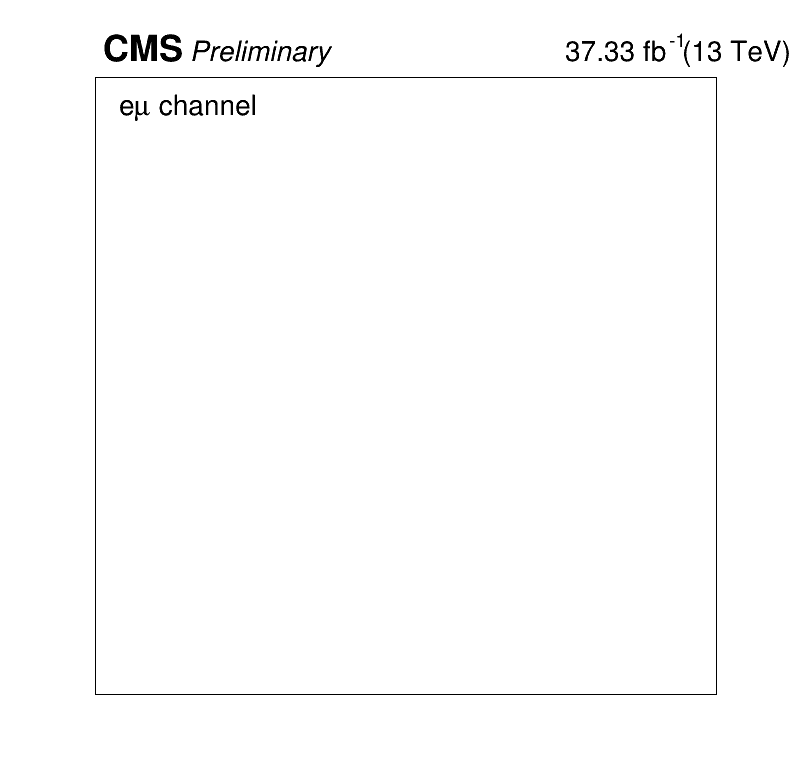

In [15]:
# x bins
x = FloatVector([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975])
if REGION == "MASSSB":
    x = FloatVector([0.125, 0.375, 0.625, 0.875])

# print(os.system("ls "+out_dir+"/root_files/"))
for mass in masses:
# def wrapper_mass(mass):    
    in_file = INPUTDIR+"/"+REGION+"/root_files/shape_v1_20230430wp80_ANv3"+mass+"_v1.root"
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

    print(mass)
    
    f = rt.TFile(out_file)
#     rt.gDirectory.cd("signal_region")
#     rt.gDirectory.ls() 

    for sys0 in list_sys:
        c, _ = draw_sys_ratio_bysource(ERA, f, sys0, mass)
    
    for sys in list_sys_smoothing:
    
        # draw syst by source & construct sys/nom dictionary (needed for smoothing)
        c, dic_smooth = draw_sys_ratio_bysource(ERA, f, sys, mass) 

        # smoothing
        for i, process in enumerate(PROCESSES):
            print(sys)
            if sys=="isr" or sys=="fsr" or sys=="QCDscale":
                if i>2:
                    continue
            yup = FloatVector(dic_smooth[process+sys+'Up'])
            ydown = FloatVector(dic_smooth[process+sys+'Down'])
            n = dic_smooth[process+sys+'Nom']
            n1 = n
#             if "scale" in sys and "e" in ERA:
#                 n_data = dic_smooth[process+sys+'NomData']
#                 n1 = n_data            
            w = np.sqrt(n1)
            w = FloatVector(w)
            lup = limma.weightedLowess(x, yup, w, span=0.4, output_style="lowess")
            ldown = limma.weightedLowess(x, ydown, w, span=0.4, output_style="lowess")
            smoothed_up = np.array(lup[0])
            smoothed_up[np.isnan(smoothed_up)] = 1
            smoothed_down = np.array(ldown[0])
            smoothed_down[np.isnan(smoothed_down)] = 1
#             print(process, n, yup, smoothed_up, smoothed_down)    

            # write smoothed histogram
            nbin = 20
            if REGION == "MASSSB":
                nbin = 4
            if "JEC" in sys:
                h_Up = rt.TH1D(process+"_CMS_scale_j_"+YEAR+"Up", process+"_CMS_scale_j_"+YEAR+"Up", nbin, 0, 1)           
                h_Down = rt.TH1D(process+"_CMS_scale_j_"+YEAR+"Down", process+"_CMS_scale_j_"+YEAR+"Down", nbin, 0, 1)                 
            elif "scale_m" in sys:
                h_Up_scale = rt.TH1D(process+"_CMS_scale_mUp", process+"_CMS_scale_mUp", nbin, 0, 1)           
                h_Down_scale = rt.TH1D(process+"_CMS_scale_mDown", process+"_CMS_scale_mDown", nbin, 0, 1)                       
                h_Up_res = rt.TH1D(process+"_CMS_res_mUp", process+"_CMS_res_mUp", nbin, 0, 1)           
                h_Down_res = rt.TH1D(process+"_CMS_res_mDown", process+"_CMS_res_mDown", nbin, 0, 1)   
            else:               
                h_Up = rt.TH1D(process+"_"+sys+"Up", process+"_"+sys+"Up", nbin, 0, 1)           
                h_Down = rt.TH1D(process+"_"+sys+"Down", process+"_"+sys+"Down", nbin, 0, 1)           
            for nb in range(nbin):
                # average
                avg = (math.fabs(1-smoothed_up[nb])+math.fabs(1-smoothed_down[nb]))/2
                h_Up.SetBinContent(nb+1, n[nb]*(1+avg))
                h_Down.SetBinContent(nb+1, n[nb]*(1-avg))
                if "scale_m" in sys:
                    h_Up_scale.SetBinContent(nb+1, n[nb]*(1+math.fabs(1-smoothed_up[nb])))
                    h_Down_scale.SetBinContent(nb+1, n[nb]*(1-math.fabs(1-smoothed_up[nb])))                               
                    h_Up_res.SetBinContent(nb+1, n[nb]*(1+math.fabs(1-smoothed_down[nb])))
                    h_Down_res.SetBinContent(nb+1, n[nb]*(1-math.fabs(1-smoothed_down[nb])))                        

            write_sys_hist(out_file, h_Up, h_Down)
            if "scale_m" in sys:
                write_sys_hist(out_file, h_Up_scale, h_Down_scale)
                write_sys_hist(out_file, h_Up_res, h_Down_res)
#         f.Close()    
        # draw smoothed histogram
        hist2 = []
        f1 = rt.TFile(out_file)
        hist2.append(f1)
        if sys == "JEC":
            c, _ = draw_sys_ratio_bysource(ERA, f1, "CMS_scale_j_"+YEAR, mass, False)
        elif "scale_m" in sys:
            c, _ = draw_sys_ratio_bysource(ERA, f1, "CMS_scale_m", mass, True)           
            c, _ = draw_sys_ratio_bysource(ERA, f1, "CMS_res_m", mass, True)           
        else:
            c, _ = draw_sys_ratio_bysource(ERA, f1, sys, mass, True)
#         f1.Close()
#     f.Close()

        # rt.gDirectory.cd("signal_region")
        # rt.gDirectory.ls()

 # Draw by process

Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345ttbarUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345ttbarDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345wwUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345wwDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345zpUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-1700_CH-345zpDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-2500_CH-345ttbarUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Zp-2500_CH-345ttbarDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/em16/SR/AN/Z

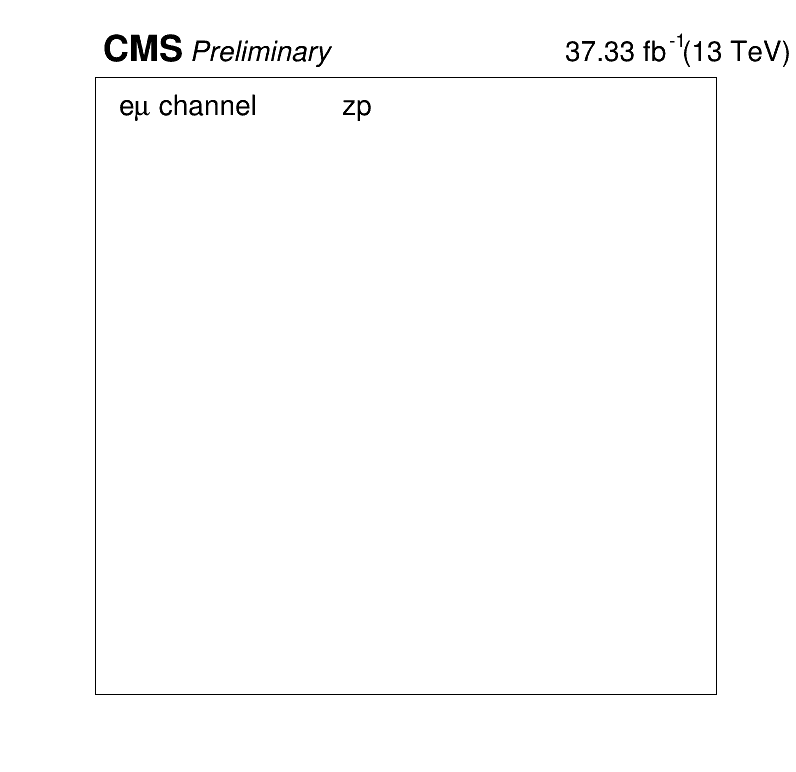

In [16]:
# if REGION == "SR":
#     for mass in masses:
#         out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

#         f = rt.TFile(out_file)

#         rt.gDirectory.cd("signal_region")

#         processes = ["ttbar", "ww", "zp"]

        
#         for process in processes:
#             if process == "ttbar":
#                 list_sys = ["hdamp", "UE", "toppt", "met", "metjer", "metue", "btagSFbc_correlated", "btagSFbc"+year]
#             else:
#                 list_sys = ["isr", "fsr", "met", "metjer", "metue"]
#                 if "e" in ERA:
#                     list_sys += ["eff_e"]
#                 else:
#                     list_sys += ["eff_m"]            
                
#             c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = True)        
#             c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Down", smoothed = True)